# **Store Item Demand Forecasting with LightGBM**
* We are given 5 years of store-item sales data and asked to predict 3 months of sales for 50 different items at 10 different stores.
* It is actually a **"Time Series problem"**. The interesting part is that I will try to handle it with a **Machine Learning** approach by using the **LightGBM model**.
* The challenge is here that normally machine learning algorithms can not be used for **"Time Series"** problems(because they are not time series algorithms) unless we are able to generate features that represent **"Time Series"** patterns for the Machine learning models. Once we are able to do that we actually convert the time series problem into **regression problem** which can be solved by various ML algorithms.
* Thus, the key point is here that being able to generate appropriate features for the Machine Learning model in order to handle **"Time Series problem"** as a regression problem. Let's start !
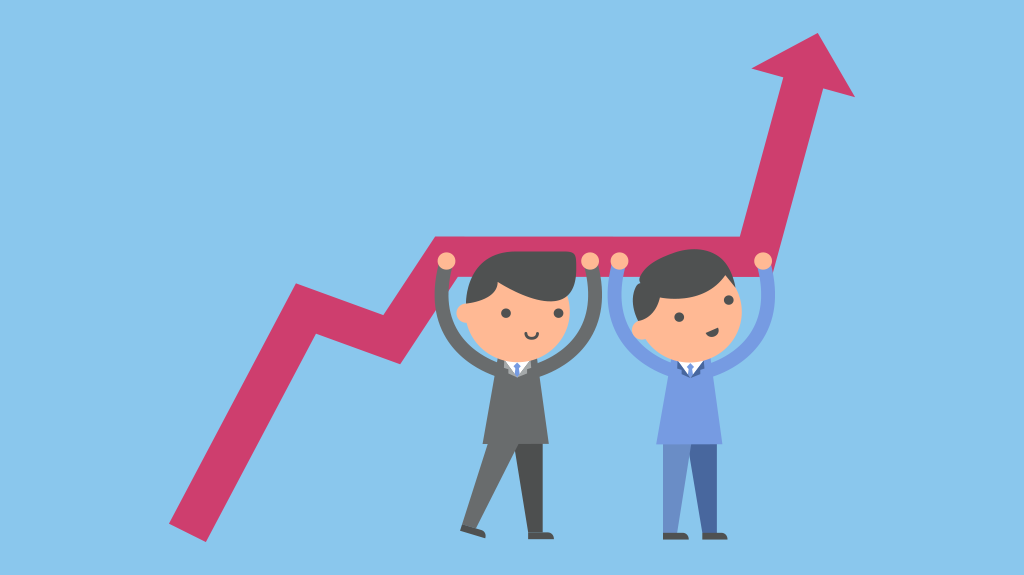
# **Business Problem**
* There are 10 different stores and 50 distinct item in each. We want to forecast a number for each distinct 50 items that tell us how many each item will be sold on each day for 3 months period in every 10 stores. 

In [1]:
# Importing the libraries that we will use throughout this project
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings 

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore') # For ignoring warnings

In [2]:
# This function will be used for exploring data
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [3]:
# Let's read datas that we are provided with
# We use parse_dates=['date'] for converting 'date' column inti 'Date Format'
train = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
train.info()
# If we didn't use "parse_dates=['date']", the 'date' column would be "object" dtype
# Since we want to use some functions of the 'Date Format' variable we had to convert it.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [4]:
test = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv', parse_dates=['date']) # Reading test data
sample_sub = pd.read_csv('../input/demand-forecasting-kernels-only/sample_submission.csv') # Reading the sample submission that is provided by Kaggle

In [5]:
# Quickly checking each set
check_df(train)

##################### Shape #####################
(913000, 4)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object
##################### Head #####################
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
##################### Tail #####################
             date  store  item  sales
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82
##################### NA #####################
date     0
store    0
item     0
sales    0
dtype: int64
##################### Quantiles #####################
       0.00  0.05  0.50   0.95   0.99   1.00
store   1.0   1.0   5.5   10.0   10.0   10.0
item  

In [6]:
check_df(test)

##################### Shape #####################
(45000, 4)
##################### Types #####################
id                int64
date     datetime64[ns]
store             int64
item              int64
dtype: object
##################### Head #####################
   id       date  store  item
0   0 2018-01-01      1     1
1   1 2018-01-02      1     1
2   2 2018-01-03      1     1
3   3 2018-01-04      1     1
4   4 2018-01-05      1     1
##################### Tail #####################
          id       date  store  item
44995  44995 2018-03-27     10    50
44996  44996 2018-03-28     10    50
44997  44997 2018-03-29     10    50
44998  44998 2018-03-30     10    50
44999  44999 2018-03-31     10    50
##################### NA #####################
id       0
date     0
store    0
item     0
dtype: int64
##################### Quantiles #####################
       0.00     0.05     0.50      0.95      0.99     1.00
id      0.0  2249.95  22499.5  42749.05  44549.01  44999.0
sto

In [7]:
check_df(sample_sub)

##################### Shape #####################
(45000, 2)
##################### Types #####################
id       int64
sales    int64
dtype: object
##################### Head #####################
   id  sales
0   0     52
1   1     52
2   2     52
3   3     52
4   4     52
##################### Tail #####################
          id  sales
44995  44995     52
44996  44996     52
44997  44997     52
44998  44998     52
44999  44999     52
##################### NA #####################
id       0
sales    0
dtype: int64
##################### Quantiles #####################
       0.00     0.05     0.50      0.95      0.99     1.00
id      0.0  2249.95  22499.5  42749.05  44549.01  44999.0
sales  52.0    52.00     52.0     52.00     52.00     52.0


In [8]:
# As I mentioned above we will generate some features, so this features have to generated both in test and train set
# For that reason I am concatenating these sets under the name 'df'
df = pd.concat([train, test])
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [9]:
df.isnull().sum() 
# As we see they are '45000' missing values in 'sales' column. It's because of test set, since our aim is to forecast that values 
# And theres is '913000' missing values in 'id' column and that is because we have 'id' column in test set but not in train set.Our final aim will be building 
# a model on train set and forecasting the 'sales' values of 'test' set due to 'id' column of the test set. Therefore, we have this column in test set but 
# not in train set 
# Since we created 'df' dataframe by concatenating 'train' and 'test' set, as a result we are facing such kind of missing values but it's not a problem
# I just wanted to clarify what are they 

date          0
store         0
item          0
sales     45000
id       913000
dtype: int64

In [10]:
test['date'].min(), test['date'].max() # We want forecasting for first 3 months of 2018

(Timestamp('2018-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [11]:
train['date'].min(), train['date'].max() # We have the whole time period before the 'Timestamp('2018-01-01 00:00:00')' ==> which is begining of 'test' set
# And it is quite reasonable, since we are dealing with time series data which ise "sequential"

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [12]:
# Let's see minimum and maximum dates in the 'df'
df['date'].min(), df['date'].max()
# We have data set for 5 years period in total

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

# **Briefly EDA for verfication of data**

In [13]:
# For seeing the distribution of sales column
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
10%          20.000000
30%          33.000000
50%          47.000000
70%          64.000000
80%          76.000000
90%          93.000000
95%         107.000000
99%         135.000000
max         231.000000
Name: sales, dtype: float64

In [14]:
# How many unique store do we have ?
df[["store"]].nunique()
# As we were expecting kinda verfication questions

store    10
dtype: int64

In [15]:
# How many items do we have ?
df[["item"]].nunique()

item    50
dtype: int64

In [16]:
# Do we have the same number of unique item in each store ?
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [17]:
# How many each unique item has been sold in each store for 5 years
df.groupby(["store", "item"]).agg({"sales": ["sum"]})

sales
                 sum
store item          
1     1      36468.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]

In [18]:
# more descriptive statistics of the previous code
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

# **Feature Engineering**
* That section is the most crucial part of this work because as I mentioned at the very beginning of the work we have to generate features that represent "Time Series" patterns in order to apply the ML models to the time series problems.

In [19]:
# Since we have 'date' column in our hands we have to generate new features from that column as much as we can 
# Normally we shouldn't hesitate to generate a lot of features even we think that it will not have a point. 
# It's better to generate as much as we can and then by looking 'feature_importance' plot we can eleminate some of them which we see that they are not useful
# features for the model.

# So, before starting : We are aming to give some features that will represent some "Time Series Pattern". And here is the first place that we are starting
# In that part by generating new features from "date" column we may catch some "Time Series Pattern" which called "seasonality" in time series terminology.
# "Seasonality" like : "Do we have patterns like : every month?, every year?, every weekend? and so on..."
# Since we expect some increase in demand for instance when it is weekend(Customers have time to visit stores), when it is beginning of the month(Customers
# receives their salary) and so on. I have to give that kind of things to the model as a feature to make the model to catch that kind of patterns. 

# So let's generate new features from 'date' column
# For that I will create function :
def create_date_features(df):
    # Since we have converted 'date' column into 'Date Format' we are allowed to use the methods that we see below(like : date.dt.month,day,year etc.) 
    df['month'] = df.date.dt.month # Which month of the corresponding year
    df['day_of_month'] = df.date.dt.day # Which day of the corresponding month
    df['day_of_year'] = df.date.dt.dayofyear # Which day of the corresponding year
    df['week_of_year'] = df.date.dt.weekofyear # Which week of the corresponding year
    df['day_of_week'] = df.date.dt.dayofweek # Which day of the corresponding week of the each month
    df['year'] = df.date.dt.year # Which year
    df["is_wknd"] = df.date.dt.weekday // 4 # df.date.dt.weekday => Starts from '0' means '0' = 'Monday'. So, '// 4' will give '1' when day number equals
    # to '5'(which corresponds 'Saturday') and '6'(which corresponds 'Sunday') and '0' for rest of them. Consequently this column will represent whether 
    # the day is weekend or not
    df['is_month_start'] = df.date.dt.is_month_start.astype(int) # Is it starting of the corresponding month
    df['is_month_end'] = df.date.dt.is_month_end.astype(int) # Is it ending of the corresponding month
    return df
# As we notice this kind of features can help us to explain the variance or change of the sales column. We actually want to find what makes "sales" column
# to change

# Since this data is related to sales, by genereting the new features(as we have generated above from 'date' column) we can catch some patterns as 
# I mentioned above. For instance by generating  df['is_month_start'] column we allow our model to investigate this question :
# 'Can beginning of month affect sales of item, or can help us to explain changes in sales column(because it is the data that all people receives their salary)'

# And for isntance by generating df['year'] column we allow our model to investigate that question : 'Can we say that for each year we have different amount
# of sales, can year will help us to explain changes in sales column'

# The same thing for instance df["is_wknd"] feature, as a human we can guess that maybe being end of the week can affect amount of sales beacuse people have
# more time to buy new item. As I said we can guess it by human but we have to also allow for the model to investigate that effect by generating new feature 
# as for instance df["is_wknd"]. So therfore we have generated that kind of features from 'date' column

# Also you may add the features such as 'Is it 8 march?' that we think it can also affect amount of sales or days like 'Is it Black Friday?'

# I haven't added that kind of features to my model but you can add and see the effect of them maybe they might boost your result
# As I said don't hesitate to add new features to your model you can elimante them later by looking 'feature_importance' metric if it is useless

In [20]:
# So let's use the function that we created above
df = create_date_features(df)
check_df(df) # Now we have more features

##################### Shape #####################
(958000, 14)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int64
day_of_month               int64
day_of_year                int64
week_of_year               int64
day_of_week                int64
year                       int64
is_wknd                    int64
is_month_start             int64
is_month_end               int64
dtype: object
##################### Head #####################
        date  store  item  sales  id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end
0 2013-01-01      1     1   13.0 NaN      1             1            1             1            1  2013        0               1             0
1 2013-01-02      1     1   11.0 NaN      1             2            2      

In [21]:
# Since after generating new features now we have 'month' column in our hands let's see more detailed descriptive statistics
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})
# For instance if we can see some differences between months in terms of "sales mean" that might mean that "month" column might have distinctiveness property
# That is why we generate new features like that one in order to catch why "sales" column changes.

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

In [22]:
df.groupby(["store", "item"])[['store', 'item', 'date', 'sales']].head()

,store,item,date,sales
0,1,1,2013-01-01,13.0
1,1,1,2013-01-02,11.0
2,1,1,2013-01-03,14.0
3,1,1,2013-01-04,13.0
4,1,1,2013-01-05,10.0
...,...,...,...,...
911174,10,50,2013-01-01,33.0
911175,10,50,2013-01-02,37.0
911176,10,50,2013-01-03,46.0
911177,10,50,2013-01-04,51.0


In [23]:
# Before starting "Lag/Shifted Features" part we have to be sure that all data have asending order due to the 'store', 'item' and 'time'. 
# Because in "Lag/Shifted Features" part we will generate new features for each 'item' in each 'store' according to 'date' order
# Simply means when we run this code 'df.groupby(["store", "item"])[['store', 'item', 'date', 'sales']].head()' we want to see sequnetial 'sales' according
# to time for each 'item' in each store
# So for being sure we have to write that code :
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

# What the above code does is : First sorts data due to 'store' value(which ranges between 1 and 10)
# We may have this situation while sorting for 'store' value: ('store' value = 1, 'item' value = 1) and ('store' value = 1, 'item' value = 2) which one 
# has to come first? by writing -by=['store', 'item',- we say if the 'store' values are same sort for 'item' value

# We solved one part of this problem, what if it faces that situation : 
# ('store' value = 1, 'item' value = 1, 'date' = 2013-01-01) and ('store' value = 1, 'item' value = 1, 'date' = 2013-01-02) which one has to come first?
# by writing -by=['store', 'item', 'date']- we say when you see both 'store' value and 'item' value are same sort for 'date'

# So, to conclude by writing above code we ensure that our data is sorted due to the 'store', 'item' and 'time'. 

# **Lag/Shifted Features**

In [24]:
# Let's first understand what is "Lag/Shifted Features" first.
pd.DataFrame({"sales": df["sales"].values[0:10],
              "lag1": df["sales"].shift(1).values[0:10],
              "lag2": df["sales"].shift(2).values[0:10],
              "lag3": df["sales"].shift(3).values[0:10],
              "lag4": df["sales"].shift(4).values[0:10]})
# For instance if we generate 'lag' features for 'sales' column, 'lag1' column means 'the amount of 1 day before sale' for each 'sale'
# 'lag1' : For '13.0' we don't have 1 day before sale, thus ==> NaN
# 'lag1' : For '11.0' we do have 1 day before sale, thus ==> 13.0
# 'lag1' : For '14.0' we do have 1 day before sale, thus ==> 11.0
# ......... and so on.

# The same principle is applied for other columns. 'lag2' column means 'the amount of 2 day before sale' for each 'sale'
# 'lag2' : For '13.0' we don't have 2 day before sale, thus ==> NaN
# 'lag2' : For '11.0' we don't have 2 day before sale, thus ==> NaN
# 'lag2' : For '14.0' we do have 2 day before sale, thus ==> 13.0
# 'lag2' : For '13.0' we do have 2 day before sale, thus ==> 11.0
# ......... and so on.

,sales,lag1,lag2,lag3,lag4
0,13.0,NaN,NaN,NaN,NaN
1,11.0,13.0,NaN,NaN,NaN
2,14.0,11.0,13.0,NaN,NaN
3,13.0,14.0,11.0,13.0,NaN
4,10.0,13.0,14.0,11.0,13.0
5,12.0,10.0,13.0,14.0,11.0
6,10.0,12.0,10.0,13.0,14.0
7,9.0,10.0,12.0,10.0,13.0
8,12.0,9.0,10.0,12.0,10.0
9,9.0,12.0,9.0,10.0,12.0


In [25]:
# Now I hope we understand what are "Lag/Shifted Features", so let's see one other example. Actually this example will be more appropriate for what we will 
# do in further steps for creating "Lag/Shifted Features"

# Now we will see "Lag/Shifted Features"  specifically for each 'item' in each 'store' which we are caring in this work.
# Because we want:  for instance in 'store' '1', how many 'item' '1' had been sold 1 day before (in'lag1' column) or how many 'item' '1' had been sold 2 day 
# before(in 'lag2' column) and so on. We have to focus on each unique 'item' in each 'store' separately, because we are seeking for some features that can help
# to find some patterns that may help us to forecast. And each 'store' may have its own pattern for each 'item'. For that reason we have to generate features
# for each unique 'item' in each 'store' separately

# Let's see an example : With this code we generate 'lag1' feature for ecah unique 'item' in each 'store' separately.
df.groupby(["store", "item"])[['sales']].transform(lambda x: x.shift(1))
# Let's do it by using function in next part 

# Before doing that I want to mention why do we need to generate that kind of feature ?

,sales
0,NaN
1,13.0
2,11.0
3,14.0
4,13.0
...,...
44995,NaN
44996,NaN
44997,NaN
44998,NaN


# **Why do we need "Lag/Shifted Features" features ?**
* As I mentioned in the beginning of notebook, we have to generate some features that represents "Time series" patterns. By using "Lag/Shifted Features" we actually add that kind of features to our data. Because if you are familiar with well-known "Time Series" statistical model like: ARIMA, Holt winters and etc, in almost all these models' formula we see that "Lag/Shifted Features" actually is used.
* For instance let's see "ARIMA" model's fomula : 

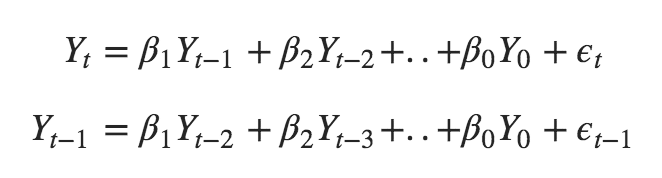
* As we see in the formula "Lag/Shifted Features" are used as **yt-1**, **yt-2** ..... These are the previous term target variable values
* From here we understand that using "Lag/Shifted Features" as a feature for machine learning model really makes sense for representing "Time Series" pattern. 


# **Adding "Random Noise" to the "Lag/Shifted Features"**
* We understand that using "Lag/Shifted Features" really makes sense since statistical time seris models also use that approach. But since we are building machine learning model, there is a problem. We are generating these "Lag/Shifted Features" from the target variable "sales", actually we are causing a problem which is called **data leakage** in data science literature. 
* The reason of that **data leakage** problem is that in our case, normally we shouldn't generate features by using target variable when we are working on ML project. Because it causes **overfitting** to the train data. Model notices target variable base features explains "target" column well, and focuses more to that columns. Consequently, it loses its "generalization" ability.
* Since we feel obliged to generate features from target column in our case(beacuse we have only this feature in our hands and from statistical time series models like ARIMA uses that values for forcasting and we also have to use to represent time series patterns), for avoiding "overfitting" situation, as a solution we add "Random, gaussian noise" to "Lag/Shifted Features" on purpose.
* This will cause, model will not to learn the exact values of target variable and as a result we avoid "overfitting" situation

In [26]:
# Let's first create "Random Noise" function, for using when we want 
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),)) # Gaussian random noise

In [27]:
# And let's create "Lag/Shifted Features" by using this function
# Since we will create more than 1 "Lag/Shifted Features" I created that function.
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe) # Adding random noise to each value.
    return dataframe

In [28]:
# As I said we are creating more than 1 "Lag/Shifted Features". So this list represents all "Lag/Shifted Features" that will be created
# We started with '90' days gap, because we are aming to predict "test" set in the final stage. Our ultimate goal is to be successful in the "test" set
# So if we don't start '90' days gap, majority of our new generated lag columns will be 'NaN'. 
# For instance if we intend to create 'lag1' feature, this feature will be almost 'NaN' for the 'test' data, and we probably will not be successful in the 
# test set, since this column will be almost 'NaN' for the 'test' column. Only one observation(the observation that comes after the last observation of 'train' set
# because only for that observation we have 'lag1' feature) will not be 'NaN' others will be.

# So for that reason we start with '90' days gap. In this case we will not have any 'NaN' in the "Lag/Shifted Features" in the 'test' set.

# We add more than 1 "Lag/Shifted Features" because we will try which "Lag/Shifted Features" makes sense for our data, means you can try other values in this
# list and see the effect.
lags_list = [91, 98, 105, 112, 119, 126, 182, 364, 546, 728] 
df = lag_features(df, lags_list) # Let's create

In [29]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,39.337619,52.630459,68.626875,70.006659,68.424805,79.989116,74.967761,57.484430,97.247959,73.341915
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,65.425192,50.008857,66.998960,58.379816,74.783923,82.256064,76.812227,72.682660,82.245911,68.195383
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,57.975385,62.536084,73.306915,64.232401,72.978901,87.188588,79.840909,72.041863,97.920724,75.244484
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,74.465155,75.992872,73.392594,69.205482,65.906062,79.742467,90.437633,69.646577,78.415791,83.232965
44999,2018-03-31,10,50,NaN,44999.0,3,31,90,13,5,2018,1,0,1,62.475121,71.827260,52.689645,66.941984,50.689550,79.480584,102.614333,99.580226,99.731357,80.756041


# **Rolling Mean Features**
* "Moving Average Method" is used for forcasting "Time Series" problems. This method simply takes "n" previous target variable and averages them and returns as a new value.
* So since we know that, this kind of method is used for forcasting "Time Series" problems, again we generate new feature by using that method.
* You may ask, why we use traditional "Time Series Forecasting methods" when we generate new features. Because, normally when we work on ML problems we try to generate features that we  think this new features have an ability of predicting target variable.
* Since this kind of traditional  methods have been used for forecasting target variables, when we want to generate new features by looking these methods we become sure that  these new features will have predictive ability for predicting target variable. Because they have been used in traditional "Time Series Method", that means they have a predictive ability for target variable. 
* So since we said that while using ML approach we have to generate features that represent time series patterns, we actually get help from traditional methods for that purpose.
* We actually try to add our **variety of predictions** for target varaible to the columns as a new feature by using traditional "Time Series Methods" approach.
* So since these variety of predictions may cause overfitting to train data we add again **random, gaussian noise** to these new generated features on purpose.

In [31]:
# Let's see an example of 'rolling mean features'
# We have to first 'sift(1)' then take the previous 'n' variables. Because it's prediction of current variable, we have to leave out it.
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})
# For instance "roll2" takes previous 2 variable and averages it
# "roll3" takes previous 3 variable and averages it, you can examine by yourself.

,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,NaN,NaN,NaN
2,14.0,12.0,NaN,NaN
3,13.0,12.5,12.666667,NaN
4,10.0,13.5,12.666667,NaN
5,12.0,11.5,12.333333,12.2
6,10.0,11.0,11.666667,12.0
7,9.0,11.0,10.666667,11.8
8,12.0,9.5,10.333333,10.8
9,9.0,10.5,10.333333,10.6


In [32]:
# Let's create "rolling mean features".

def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise( # Again adding random noise
            dataframe)
    return dataframe

roll_mean_list = [365, 546] # Again you can try various variables and see the effect. While I was working I saw that these [365, 546] have an effect.
df = roll_mean_features(df, roll_mean_list)
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,39.337619,52.630459,68.626875,70.006659,68.424805,79.989116,74.967761,57.484430,97.247959,73.341915,86.116777,84.453279
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,65.425192,50.008857,66.998960,58.379816,74.783923,82.256064,76.812227,72.682660,82.245911,68.195383,86.615862,87.669832
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,57.975385,62.536084,73.306915,64.232401,72.978901,87.188588,79.840909,72.041863,97.920724,75.244484,86.713269,88.593385
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,74.465155,75.992872,73.392594,69.205482,65.906062,79.742467,90.437633,69.646577,78.415791,83.232965,88.696753,84.957500
44999,2018-03-31,10,50,NaN,44999.0,3,31,90,13,5,2018,1,0,1,62.475121,71.827260,52.689645,66.941984,50.689550,79.480584,102.614333,99.580226,99.731357,80.756041,86.507253,88.220229


# **Exponentially Weighted Mean Features**
* Another traditional "Time Series Method" is "Exponentially Weighted Mean" method. This method has parameter called _alpha_ used as smoothing factor. This parameter ranges between [0, 1]. If _alpha_ is close to 1 while taking average for last for instance 10 days(rolling mean features also was taking averages but without giving weight), it gives more _weight_ to the close days and decreases the _weight_ when going to more past days.  
* You can read about this method more on internet, but briefly normally in time series forecatsing it's better to give more _weights_ to the more recent days rather tham giving same _weight_ to all past days.
* Because more recent days have more influence to the current day. Therefore, giving more _weight_ to the more recent days makes sense.
* This method uses that formula behind in its calculations(xt : past days values) : 

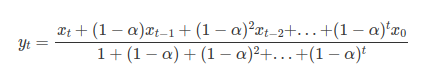
* As we see when it goes more past values it decreases the _weight_

In [33]:
# You can examine by yourself from this example
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10], # It's 'rolling mean averages'
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10], # The rest is 'exponentially weighted mean averages' for different 'alpha'
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm01": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})

,sales,roll2,ewm099,ewm095,ewm07,ewm01
0,13.0,NaN,NaN,NaN,NaN,NaN
1,11.0,NaN,13.000000,13.000000,13.000000,13.000000
2,14.0,12.0,11.019802,11.095238,11.461538,11.947368
3,13.0,12.5,13.970201,13.855107,13.287770,12.704797
4,10.0,13.5,13.009702,13.042750,13.084686,12.790637
5,12.0,11.5,10.030097,10.152137,10.920146,12.109179
6,10.0,11.0,11.980301,11.907607,11.676595,12.085878
7,9.0,11.0,10.019803,10.095380,10.502722,11.686057
8,12.0,9.5,9.010198,9.054769,9.450748,11.214433
9,9.0,10.5,11.970102,11.852738,11.235259,11.342672


In [34]:
# Let's create 'Exponentially Weighted Mean Features' 

def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

# In here we have two combinations : alphas and lags. Agian we give variety of variables for both and will se which one is best. 
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# We have finished with generating new_features let's go to "One-Hot encoding" part

# **One-Hot encoding**

In [36]:
# We slected cotegoric features for  one-hot encoding
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])

In [37]:
df.head()

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,13.0,NaN,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,11.0,NaN,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,14.0,NaN,3,3,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,13.0,NaN,4,4,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,10.0,NaN,5,5,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

# **Satndardization of target variable**
* Since we are in regression problem our target variable is continuous.
* We will use LightGBM model, and this model uses 'Gradient Descent' method for optimization.
* For diminishing optimization time we prefer to standardize target variable, but you prefer not to do it as well.

In [38]:
# We are standardizing by using logarithmic transformation
df['sales'] = np.log1p(df["sales"].values)

# **Modelling**

# **Custom Cost Function**
* MAE: mean absolute error
* MAPE: mean absolute percentage error
* SMAPE: Symmetric mean absolute percentage error (adjusted MAPE). For this competition Kaggle wants 'SMAPE' metric from us. For that reason we will optimize our model for this metric.

In [39]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

# Calculating SMAPE for LightGBM output:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

# **Time-Based Validation Set**
* We have to define validation set for optimizing our model. Normally in typical ML projects we define validation set either 'Hold-out validation set' approach or 'K-fold cross validation' approach. Since it's time series problem and order of the time matters 'K-fold cross validation' approach will not be useful.
* Thus, we will continue with 'Hold-out validation set' approach.
* But there is one point we have to think, which part has to be 'Hold-out validation set' ?. 
* As we know we optimze algorithm due to validation set, means our aim will be to fit validation set in a possible the best way. 
* Apart from that our ultimate goal will be assessed in 'test set'. Thus, we have to define validation set similar to 'test' set. We know that our 'test' set belongs to **first 3 months of 2018**.
* For that reason we also define our 'hold-out validation' set as a **first 3 months of 2017**. Because we think that that part will be similar to 'test' set. Again, since we will optimize our model due to the 'hold-out validation' set we want this set to be similar to 'test' set.
* So we decided **first 3 months of 2017** to be 'holf-out validation' set. We will remove that part from train set.
* Since by removing that part from 'train' set we ruin the sequential order of  time for the **year 2017**, we will remove also rest part of the **2017** from the training set.(Because by removing first 3 months of 2017 for validation set, after 2016's last day, 2017's 4th month will come so as we see the order has been ruined) 

In [40]:
# Let's define train and validation set.
train = df.loc[(df["date"] < "2017-01-01"), :] # Until beginning of 2017
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :] # First 3 months of 2017

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 142), (45000,), (45000, 142))

# **LightGBM Model**

In [41]:
# LightGBM parameters : Actually that parameters is pretrained parameters means this parameters have been found by GridSearch/RandomizedSearch. 
#So I am writing using it directly, normally it should have been found by GridSearch/RandomizedSearch methods. 
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 11000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [42]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=200)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)  

smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.370051 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[200]	training's l1: 0.142266	training's SMAPE: 14.5703	valid_1's l1: 0.145007	valid_1's SMAPE: 14.876
[400]	training's l1: 0.13451	training's SMAPE: 13.7948	valid_1's l1: 0.138969	valid_1's SMAPE: 14.271
[600]	training's l1: 0.132279	training's SMAPE: 13.5724	valid_1's l1: 0.136775	valid_1's SMAPE: 14.0507
[800]	training's l1: 0.131006	training's SMAPE: 13.445	valid_1's l1: 0.135424	valid_1's SMAPE: 13.9146
[1000]	training's l1: 0.130101	training's SMAPE: 13.3544	valid_1's l1: 0.134636	valid_1's SMAPE: 13.8353
[1200]	training's l1: 0.129436	training's SMAPE: 13.2876	valid_1's l1: 0.134118	valid_1's SMAPE: 13.7831
[1400]	training's l1: 0.128935	training's SMAPE: 13.2372	valid_1's l1: 0.133755	valid_1's SMAPE: 13.7465
[1600]	training's l1: 0.128549	training's SMAP

13.516451973042976

# **Feature Importance**

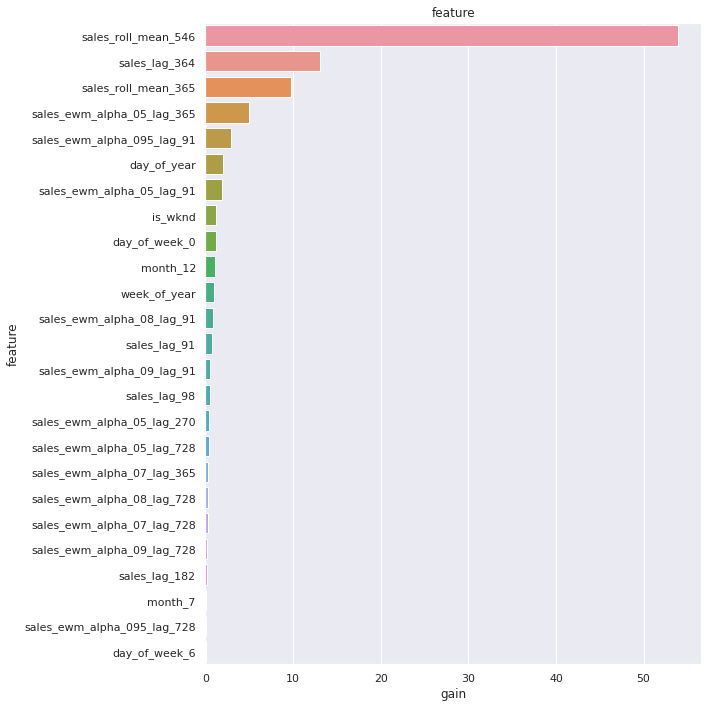

In [43]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))



plot_lgb_importances(model, num=30, plot=True)


# **Final Model**

In [44]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}


# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

test_preds = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.434696 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [45]:
# Submission part
submission_df = test.loc[:, ['id', 'sales']]
submission_df['sales'] = np.expm1(test_preds)
submission_df['id'] = submission_df.id.astype(int)

submission_df.to_csv('submission.csv', index=False)
submission_df.head(20)

,id,sales
0,0,11.670650
1,1,14.205857
2,2,14.074521
3,3,14.435719
4,4,16.057732
5,5,16.781641
6,6,18.949812
7,7,11.738320
8,8,14.118203
9,9,14.230395
